In [1]:
import sys
sys.path.append("../")

from molNet.utils.mol.properties import has_confomers
from rdkit import Chem 
from rdkit.Chem import rdMolDescriptors,Descriptors3D ,GraphDescriptors, Descriptors, rdmolops, rdForceFieldHelpers 
import pickle
import os
import numpy as np

In [2]:

modules=[rdMolDescriptors,Descriptors3D,GraphDescriptors,Descriptors,rdmolops]
modules={mod.__name__:mod for mod in modules}

data_to_work_pckl = "rdkit_feat_ex_data_to_work.pckl"
unsucsess_mods_pckl = "rdkit_feat_ex_unsucsess_mods.pckl"
sucsess_mods_pckl = "rdkit_feat_ex_sucsess_mods.pckl"

BAD_LIST=["^SplitMolByPDBResidues$","^SplitMolByPDBChainId$","SanitizeMol","AUTOCORR2D_[0-9]",
          "^_","_$"#internal use,
          
         ]
BLACK_LIST_MODULES=[rdForceFieldHelpers]

In [3]:
test_smiles=[
    'C'*20,
    'C1=CC=C(C=C1)C2=CC(=CC(=C2)C3=CC(=CC4=C3SC5=CC=CC=C54)N(C6=CC=CC=C6)C7=CC=CC=C7)C8=CC(=CC9=C8SC1=CC=CC=C19)N(C1=CC=CC=C1)C1=CC=CC=C1',
 'CC(C(=O)NCCN1C(=O)C=CC(=N1)N2C=CC=N2)OC3=CC(=CC=C3)Cl',
 'CCCCCC1=CC=C(C=C1)OCCCC2=C(C(=C(OC2C3=CC=C(C=C3)ON=[N+]=[N-])CCCOC4=CC=C(C=C4)CCCCC)C)CCCOC5=CC=C(C=C5)CCCCC',
 'C1CCC2=C(C1)C3=C(S2)N=C(N(C3=O)CC(=O)NC4=C(C=CC(=C4)C(F)(F)F)Cl)C5=CC=CC=C5',
 'CCCCC(CN1C(=O)C=CC1=O)O',
 'C[C@H]([C@@H](C1=N/C(=C/C2=CC(=C(C=C2)O)F)/C(=O)N1CC=O)N)O',
 'CCC1CC(CC(O1)C2=CC=C(CC2)C3=CC=C(C=C3)C4CC(=O)N4C5=CC=CC=C5)C',
 'CC[C@@H](C1=CC=NC=C1)NC(=O)C2=CSC3=NC(=CN23)C4=CC=C(C=C4)C(F)(F)F',
 'CC1(CCCCC1)/C(=C\\2/C=CC(CC2=C)CC3=CCC(C=C3)OC)/O',
 'CCCCCCCCCCCCCCCCCC(=O)OC[C@H](CO[P@](=O)(OC)OC1[C@@H]([C@H](C([C@H]([C@H]1O[C@@H]2[C@H]([C@H]([C@@H]([C@H](O2)COCC3=CC=CC=C3)OCC4=CC=CC=C4)OCC5=CC=CC=C5)OCC6=CC=CC=C6)OC(=O)C)OC(=O)C)OC(=O)C)O[C@@H]7[C@H]([C@H]([C@@H]([C@H](O7)COCC8=CC=CC=C8)OCC9=CC=CC=C9)OCC1=CC=CC=C1)OCC1=CC=CC=C1)OC(=O)CCCCCCCCCCCCCCCCC',
 'CCC1=CC(=CC=C1)N2C(=O)C3=CC(=NN3C[C@]2(C)C(=O)NC4CCCCCCC4)C(C)C',
 'CCCCCCCCCCC(C)C1(CC2=CC=CC=C2OC1=O)O',
 'CC1(CC(C2=C1C=C(C(=C2)COC3=NC=C4[C@@H]5[C@H]([C@@H]5C(C4=C3)(F)F)C(=O)O)F)C6=CC=CC=C6C(F)(F)F)C',
 'C1=CSC(=C1)C(C2=CC=C(C=C2)F)NC(=O)COC3=C(C=C(C=C3)F)Br',
 'C[C@H]1CN(CCN1C2=CC(=NC3=CC(=NN32)C)C)C4=CC=CC=C4OC',
 'C1=CC=C(C=C1)C2=NC(NC(=N2)C3=C4C(=CC=C3)OC5=C4C=C6C7=CC=CC=C7N(C6=C5)C8=CC=CC=C8)C9=CC1=C(C=C9)C2=CC=CC=C2C11C2=CC=CC=C2C2=CC=CC=C12',
 'CN1C2=C(C(=O)NC1=O)N(C(=N2)SCCCO)CCCC3=CC=CC=C3',
 'C1CCN(C1)C(=O)N2CCC(CC2)C(=O)NCC3=CC=C(C=C3)N4CCOCC4',
 'COC1=C(C(=C2C(=C1)C3=C(N=C2C4=CC(=CC=C4)Br)N5C=CC=CC5=N3)OC)OC',
 'COCCNS(=O)(=O)C1=CC=C(C=C1)C(=O)NCCC2=CC(=CC=C2)Cl',
 'CCCCC(=O)C1=CC=C(C=C1)C(N)N=[N+]=[N-]',
 'CCCNC(=O)[C@@H](C)NC(=O)C1=CC(=O)NC2=CC=CC=C21',
 'CSCCC(C(NC1=NC(=CS1)C2=CC=CC(=C2)C3=CC=NC=C3)O)N',
 'C1CC1COCC(CCl)C2=CC=C(C=C2)Cl',
 'CCCC(C)(C(=O)N(CC1CCCCC1)C2CC2)N',
 'CN(C)C1=CC=CC=C1[S+]=O',
 'CC1=CC=CC=C1OCCCCN2C3=CC=CC=C3N=C2C4CC(=O)N(C4)C',
 'CC1CCN(CC1)C2=NC=CC(=N2)NCC3=CC=CO3',
 'CC1=CC=C(C=C1)CN(C)C2=C(C=C(C(=C2)C(=O)O)N)F',
 'CN1C=C(C=N1)C2=CNC(=C2)C(=NC=N)N3CCN(CC3)C4=NC=C(C=N4)C(C5=CC=C(C=C5)F)(C(F)(F)F)N',
 'CN(C1CCN(CC1)C2=CC=C(C=C2)OC[C@H]3CCN4C=C(N=C4O3)[N+](=O)[O-])C5=CC=C(C=C5)OCC6=CC=C(C=C6)OC(F)(F)F',
 'C[C@H](CCC(C(C)C)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2[C@@H](C[C@@H]4[C@@]3(CC[C@H](C4)NCCCNCCCCN)C)OCC5=CC=CC=C5)C',
 'CC1=C(C=CC=C1N)COC2=CC3=C(C=CC=N3)C=C2',
 'C1=CC=C(C=C1)N2C3=C(C4=CC=CC=C42)C5=C(C=C3)C6=C(N5C7=CC=CC=C7)C=CC8=C6OC9=C8C=C(C=C9)C#N',
 'CCOPCC1=CC(=C(C=C1)NC2=NC=C(C(=N2)NC3=C4C(=C(C=C3)C5=CCN(CC5)C(=O)N)CN(C4=O)C)C(F)(F)F)OC',
 'CC(C)(C)CNC(CN=[N+]=[N-])C1=CC=C(C=C1)Cl',
 'CC(=O)C1=CN(C2=C(C1=O)C=CC(=C2OC)C3=CC4=C(S3)C(CCC4(C)C)N=[N+]=[N-])C5CC5',
 'C1C(CC1NC(=O)C2=NC=CN=C2C(=O)N)C3=CC(=CC=C3)Cl',
 'CCN(CC(=O)NC1=C(C=CC=C1F)F)C(=O)CCC2=C(C=C(C=C2)C)C',
 'COC1=CC(=CC(=C1)NC(=O)C2=NN=C(C=C2)Cl)OC',
 'C1C2C1(C(=NC3=C2C4=NC(=C(N=C4C5=NC(=C(N=C35)C#N)C#N)C#N)C#N)C#N)C#N',
 'CCCCNC1=C(C(=CC(=C1)CN(CC2=CC=CC=C2)NCC3=CC=CC=C3)S(=O)(=O)N)OC4=CC=CC=C4',
 'CC1=CC2=NC(=NN2C=C1)NC(=O)C3=CC(=CC=C3)N',
 'COCC1=CC(=CC=C1)OC2=CC=CC(=C2)CCl',
 'CN1C=CC=C1/C=N\\NC(=O)/C(=C\\C2=CC=CS2)/NC(=O)C3=CC=CC=C3',
 'C1CCN(C1)[C@@H](C2=CC3=C(C=C2)OCO3)C4=C(C5=CC=CC=C5OC4=O)O',
 'CC(C)(C)C(=O)NCC1=C(C=CC=C1OC)C(=O)O',
 'CC1=C(C(C(=C(N1C(=O)OCOCOCCNC)C)C(=O)OC(C)C)C2=CC(=CC=C2)[N+](=O)[O-])C(=O)OCCOC',
 'COC1=CC(=C(C=C1)N2C(=O)/C(=C/C3=CC=C(C=C3)C(=O)OC)/SC2=O)OC',
 'CN1C=CN=C1C(C2CCN(CC2)CCN3C4=CC=CC=C4OC3=O)O',
 'C[C@@H](CNC(=O)[C@@H](C)OC(=O)C1=CC=C(C=C1)N2CCCC2=O)C3=CC=CC=C3',
 'CCC1=CC=C(C=C1)N(C2=C3C=CC4=C5C3=C(C=CC5=C(C=C4)N(C6=CC=C(C=C6)CC)C7=CC(=CC(=C7)C8=CC=C(C=C8)F)C9=CC=CC=C9)C=C2)C1=CC(=CC(=C1)C1=CC=C(C=C1)F)C1=CC=CC=C1',
 'C[C@]12CC[C@@H](CC1[C@@H]3[C@@H](C4C2CC[C@]5(C4CCC5=C=C)C)OC(O3)(C)C)N=[N+]=[N-]',
 'CCC1=NC=C(N1)S(=O)(=O)NCCN(C)C',
 'CC1=C(C2=C3C(=CC(=C2)C4=CC=CC=C4)N=CN=C3N1C5=CC=NC=C5)/C=C\\C=C',
 'CCN1C(=C(C(=N1)C)Cl)CS(=O)(=O)N',
 'C1=CC=C(C=C1)CC2=C(N=NN2C3=CC(=CC=C3)[N+](=O)[O-])C#N',
 'C1=CC=C2C(=C1)C3=C(C=N2)N(C=[N+]3[O-])[O-]',
 'C1COCCC1(C#N)C2=CC(=CC=C2)SC3=CC=C(C=C3)N',
 'CC[C@H](C(=O)N1CCN(CC1)C(=O)OCC)N(C2=C(C=CC(=C2)C)C)S(=O)(=O)C',
 'CCNC(=O)OC1=NC2=C(N=C(N=C2N1CC3=CC(=CC=C3)CN4CCCC4)OCCOC)N',
 'CCS(=O)(=O)N1CCC2(C1)CN(C2)C3=CC=CC=N3.C(=O)(C(F)(F)F)O',
 'CCC1=CC=CC=C1.CNC(=O)/C(=C\\CC1=CC=NC=C1)/C(=O)N.C#C',
 'CCCCCCCCCCCCCCCCCC(=O)N(CCCCCCCCCCCC)[C@H]1[C@H]([C@H]([C@@H]([C@H](O1)CO)O)O)NC(=O)[C@H](C)NC(=O)CCC(=O)O',
 'C1CC2=CC=CC=C2[C@H]([C@@H]1CC3=CC=CC=C3)N(CC4=CC=NO4)C(=O)CN',
 'CCCSC1=NC(=C(C(=N1)C)N=NC2=CC=C(C=C2)C)C',
 'CN(CC#CC(=O)C1=CC=CC=C1)C2=CC=C(C=C2)Cl',
 'CC1=C(C(NC(=S)N1)C2=CC=C(C=C2)OCC3=CC=CC=C3)C(=O)C4=CC=CC=C4',
 'CC1=CC(=CC=C1)OC(=O)C23CC4CC(C2)CC(C4)(C3)Cl',
 'COC(=O)CN1C2C(NC(=O)N2)NC1=O',
 'CC1=C(SC2=CC=CC=C12)C(=O)C[NH+]3CCN(CC3)C4=[NH+]C=C(C=C4)C(F)(F)F',
 'CCCC=CNC1=C(C=C(C=N1)C2=CC(=CC=C2)C(=O)C(C)C3CCCCN(CC3)C(=O)OC(C)(C)C)NC4=[N+](C(=C(C=C4)OC)OC)C',
 'CN(C1CCNC1)C(=O)/C=C/C2=CC=CC=C2Br',
 'CN1CN(C2=CC=CC(=C21)C(=O)NC[C@H]([C@@H]3CC4=CC=CC=C4CN3)O)C5CCOCC5',
 'CNC(=O)C1(C=C(C(=C(N1)O)O)C(=O)NCC2=CC=C(C=C2)F)CC3=CC=CC=C3',
 'CC(C)(CCN)CNC1=CC2=C(C=C1)NC(=O)O2',
 'C[C@H](C1=NN=C(N1C2=CC=CC=C2)SCC(=O)NC3=NC(=CS3)C4=CC=C(C=C4)F)[NH+](C)C',
 'C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])NC(=O)C2=C(C=CN=C2)[N+](=O)[O-]',
 'C[C@@H](CC[C@H]1[C@@H](OC(O1)(C)C)CCC=C)C[C@H]([C@@H](C)C(=O)O[C@@H](C[C@H](C)CC=C)CO[Si](C2=CC=CC=C2)(C3=CC=CC=C3)C(C)(C)C)OCOC',
 'CC(C)(COCC=C)N=C=O',
 'CC(C)(CNC1=CC(=CC=C1)OC2=CC=CC=C2)N.Cl',
 'C[C@@]1([C@H]([C@@H](O[C@]1(C#N)N2C=CC(=NC2=O)N)COP(=O)(O)OP(=O)(O)OP(=O)(O)O)O)O',
 'CCC(C)CCC(=O)C1CCCC2(C1)CCC(CC2)C(C)C',
 'C(CCCN)CCC(=O)NCC(C(F)(F)F)O',
 'CC(C)(C)C1=CC=C(C=C1)CN2C=NC(=N2)CNC',
 'CC1=CC=C(C=C1)CSC2=NN=C(N2CC=C)C3=CC=C(C=C3)Br',
 'CCOC1=C2C=CC=C(C2=CC3=CC=CC=C31)C(C)O',
 'CC(=O)NC1=NC(=C(S1)C2=CC=CC=C2)CCC3=CC=C(C=C3)N=C(N)N',
 'CC(C)(CCC(=O)NCC1=C(N=CC=C1)OC)N',
 'CCOC1=CC=CC(=C1OCC2=CC=CC=N2)CO',
 'C1=CSC(=C1)C(=O)NC2=C(C=C(C=C2)I)C(=O)NCCCCO',
 'CN(C)CC=CC(=O)N1CC[C@H](C1)NC2=NC=NC3=C2C=C(N3)C#CCOC4=CC=CC=C4Cl',
 'CC(=CCC1=CC=C(C=C1)OC)C2=CC3=CC=CC=C3C=C2',
 #'CC[C@@H](C)[I-]C1CCC(CC1)C',
 'CC1(CC(C(N1[O])(C)C)NC(=O)C=C)C',
 'CN(C)C1CN(CCC1O)SC',
 'CCCC[C@]1(CS(=O)(=O)C2=C(C=C(C=C2)N(C)C)[C@@H]([C@@H]1O)C3=CC(=CC=C3)NC(=O)CCCCN(C(=O)C)C(=O)[C@@H]([C@H]([C@@H]([C@@H](COC(=O)C)OC(=O)C)OC(=O)C)OC(=O)C)OC(=O)C)CC',
 'CN(C)CCCN(CC1=CC(=C(C=C1)Cl)Cl)S(=O)(=O)C2=CNC(=C2)C(=O)N3CCCC3',
 'CCC1=CC=C(C=C1)CCC(=O)NC2=CC=NN2C(C)C',
 'C1[C@@H](CC(=O)O[C@H]1C2=CC=CC=C2)C3=CC=CC=C3',
 'CCC1=CC=C(C=C1)C(C)N[C@H](C)C2=CC=CC=C2Br',
 'C1C=CC=CC1(C2=CC=CC=C2)C3=NN(N=N3)N=[N+]=[N-]',
 'CCNCC1CCCN(C1)C2=NC3=CC=CC=C3N=C2C',
 'C1=CC=C2C(=C1)C3=C(N2CC4=CC(=C(C(=C4)F)F)F)C=CC(=C3)N(C5=CC=C(C=C5)C#N)C6=CC7=C(C=C6)N(C8C7C=CC=C8)CC9=CC(=C(C(=C9)F)F)F',
 'CC1=NC(=C(C=C1)N2C=C(C=N2)CCO)N',
 'CCCNCC(C)(C)CCC1=CC=C(S1)Br',
 'CNC(=O)C1[C@H]2[C@H](C(C(C1C(=O)NCC3=CC=CC=C3)O2)OC(=O)CCl)O',
 'C1C(N(C(=O)C1I)C2=CC=C(C=C2)Cl)C3=CC(=CC=C3)OC4=NC=CN=C4',
 'CCC1=CC2=C(C=C1)N=C(S2)N(CC3CCCO3)C(=O)C4=CC(=CC=C4)S(=O)(=O)CC',
 'C1CCC(C1)(CCCOCC(F)(F)F)CO',
 'CC1=CC(=C(C=C1)F)NC(=O)NC2=CC=C(C=CC2)C3=C4C(=CC=C3)NN=C4N',
 'C1=CSC(=C1)C2=NOC(=N2)CNC(=S)NC3=CC=C(C=C3)CC#N',
 'CC.CC.CC.CCC1CN(CCN1CC2=CC=CC=C2)C3=CC=CC(=C3C(=O)N(C)CC4=CC(=C(C=C4)OC)OC)C=O',
 'CCCCN1CCN(C(=O)C1=O)CC2=NN=C(O2)C(C)(CC3=CC=CC=C3)N',
 'C[C@@H](C1=CC=CC=C1)C(=O)N[C@H]2COC3=CC=CC=C3[C@@H]2OC',
 'CCCC1=NC=CN1CC2=CC=C(C=C2)C(=NO)N',
 'CN1C=C(N=N1)CC(C2=COC=C2)NN',
 'CC(=O)OCC(=O)[C@]1(CC[C@@H]2[C@@]1(C[C@@H]([C@H]3[C@H]2CC(C4=CC(=O)CC[C@]34C)CN(C)C5=CC=CC=C5)OC(=O)C(F)(F)F)C)O',
 'CCCNC(CCC1=CN=CC=C1)C2=CN(N=C2)CCC',
 'C1=CC2=C3C(=C1NCCNCCO)C(=O)C4=C(C3=NN2CCCN)C=CN=C4',
 'C1=CC(=C(C(=C1)Cl)NC2=NC=C(N=C2)C(=O)O)Cl',
 'C=CCC1=CC=CC=C1OCC2=CC=C(O2)C(=O)NC3=C(C=C(C=C3)[N+](=O)[O-])C#N',
 'CC1=C(C(=CC=C1)N(C)N)OCC2=CC=CC=N2',
 'CCN1C=C(C(=N1)C(=O)NCC(C)C)NC(=O)C2=NN(C=C2)COC3=C(C(=CC=C3)Cl)Cl',
 'B(C)(C1=CC=CC=C1C2=NC(=CC=C2)N)F.CC',
 'CC(C1=C(C2=CC(=C(C=C2N=C1)OC)OC)C3=CC(=C(C=C3)OC)OC)O',
 #'CC(=C)C(=O)OCCP12(C3=CC=CC4=C3C(=CC=C4)O1)C5=CC=CC6=C5C(=CC=C6)O2',
 'CN(C)CC1=C(C2CCC1C2)C3=CC4=C(C=CC=C4S3)OC',
 'CC(C)C(CC1=CSC(=N1)CCOCC(F)F)N',
 'C1CN(CCN1)CC2=CC3=C(O2)C=C(C=C3)CN',
 'CN1C=CC=C1CN(CC2=CC=CO2)C(=O)CN(CCOC)C(=O)C=CC3=CC=CC=C3',
 'C=C/C=C\\C=C\\C1=CC(=CC(=C1)N2C3=CC=CC=C3C4=C2C=C(C=C4)C5=NN=C(O5)C6=CC7=C(C=C6)N(C8=CC=CC=C87)C9=CC(=CC(=C9)C1=CC=CC=C1)C1=CC=CC=C1)C1=CC=CC=C1',
 'CC(=O)C1=CC(=C(C=C1)OCCCC(=O)NC2=CC=C(C=C2)NC(=O)COC)OC',
 'C1=CC=C(C=C1)N[C@@H](C2=CC=CC3=CC=CC=C32)[C@@H](C#N)O',
 'CC1=CC(=C(S1)NC(=O)CSC2=NN=C(N2C)C3CCCC3)C(=O)OC',
 'CC1=CC(=C(C=C1)O)/C=N/NC(=O)[C@H](C2=CC=CC=C2)O',
 'C[C@H](C1=NC=C(C=C1)Cl)NC(=O)C2=CN(N=C2COC)C',
 'C[C@H](C(=O)NC1=CC=C(C=C1)C2=CN3[C@@H](C2)C=NC4=CC(=C(C=C4C3=O)OC)OCCCCCOC5=C(C=C6C(=C5)N=C[C@@H]7CC(=CN7C6=O)C8=CC=C(C=C8)OC)OC)NC(=O)[C@@H](C(C)C)NC(=O)CCCCCN9C(=O)C=C(C9=O)OC1=CC=C(C=C1)C#N',
 'C1=CC(=CC(=C1)C(F)(F)F)C(C2=CC(=C(C=C2)F)Cl)O',
 'CC1=CC(=C(C=C1)C)OC2=NN=C(S2)CNCCOC',
 'CC(C)C1=CC(=CC=C1)OC(CN)C2=CC=C(C=C2)OC',
 'CCC1=C(N=C2C=C(C=CC2=C1)F)C/C=C\\C=C(/C=C)\\F',
 'CCCCOC(=O)CNC(CC)(CC)CO',
 'CC1=NC2=C(N1C3CCCC3)C=C(C=C2)C4=NC(=NCC4F)NC5=NC=C(C=C5)C6CCNCC6',
 'CCOC(=O)COCCN1CCSC(C1C)C',
 'C1=CC=C(C(=C1)C2=CC=C(O2)/C=C\\3/C(=NC4=CC=C(C=C4)Cl)NC(=O)S3)[N+](=O)[O-]',
 'CCS(=O)(=O)N[C@@H](CC1=CC=CC=C1)C(=O)N2CCC[C@H]2C(=O)C(=O)[C@](C)(CCCN=C(N)N)N',
 'C1CC(=O)NCC1NC(=O)[C@H](CCC2=CC=CC=C2)N',
 'CC1=CC(=CC=C1)S(=O)(=O)NCC(=O)NC2=C(C=C(C(=C2)C)Cl)OC',
 'CC(C(=O)O)N(C)C/C=C/C1=CC(=C(C=C1)F)F',
 'CCCC(C(=O)O)NC(=O)CCN1C(=O)C(=CC2=CC=C(C=C2)OC)SC1=S',
 'CCN(C)C(C1=CC=CC=C1)C(=O)NCCC(=O)O',
 'CCC(CC)N1C=CC(=N1)CN2CCC(CC2)OCCN',
 'CCNC(=S)NCCCNC1=C(C=C2C=C(C=CC2=[NH+]1)OCC)C#N',
 'CC1CCC2=NC3=CC=CC=C3C(=C2C1)C(=O)NCC4=CN=C(C=C4)N5CCOCC5',
 'CC1=CC=C(C=C1)N2C(=O)C3=C(C=CC(=C3)Br)N=C2NN',
 'CC1=CC2=NC(=NN2C=C1NC)NC(=O)CCC3=CC=CC=C3',
 'CNC1CCN(CC1)C(=O)C2=CC(=C(C(=C2)F)F)F.Cl',
 'CC1CN(C2=C(N1C(=O)CC3=C(C=C(C=C3)F)F)C=CC(=C2)C4=CN(N=C4)C5CCNCC5)C(=O)O',
 'COC=NC(C#N)C(=O)N',
 'CC[C@H](C(=O)O)SC1=NN=NN1C2=CC=CC=C2',
 'CN=C(NCCC1=CC=CC2=CC=CC=C21)NC3CCN(C3)C(=O)C4CCCC4.I',
 'CC(CC1CCCCCN1C2CCOCC2)O',
 'CCCN1C2=C(C=C(C=N2)C(=O)NC3=CC=CC=C3N4CCC5=CC=CC=C54)C(=O)NC1=O',
 'CC1=CC(=CC(=C1)OCC(=O)N(CC2=CC=C(C=C2)F)[C@@H](C)C(=O)NC(C)(C)C)C',
 'C1CN=C(N1)NN=C(C=CC2=CC=CC=C2)C=CC3=CC=C(C=C3)Cl',
 'CN(CCCN)C1=CC(=C(C=C1)C(=O)N)Br',
 'CN(CC1CCNCC1)C2CCCC(C2)C(F)(F)F',
 'CCCCN1C(C(CCC1=O)C(=O)NCC(C)O)C2=CC=CC=C2OC',
 'CC1=C(C(=NO1)C)CCNC(=NC)NCC2(CCCO2)C',
 'CS(=O)(=O)N1CC2(C1)CN(C2)C3=CC=C(C=C3)NC4=NC=C5C(=N4)N6C=CN=C6N(C5=O)C7=C(C=CC=C7Cl)Cl',
 'CC1CCC(N(C1)CC(=O)C2=C(C=CS2)Br)C',
 'C1=CC=C(C=C1)S(=O)(=O)N(CC(=O)NN=CC2=C(C=CC3=CC=CC=C32)O)C4=CC(=CC=C4)Cl',
 'CC(CNC(=NC)N1CCC(CC1)OCCCOC)COCC2=CC=CC=C2.I',
 'CC(C)(C)C1=CC(=CC(=C1)C2=CSC(=N2)CNCC(=O)O)C(C)(C)C',
 'C1=CC=C(C=C1)C2=CC(=CC(=N2)C3=CC=CC=C3)C4=CC=CC(=C4)C5=CC(=CC=C5)C6=CC=CC7=C6SC8=C7C9=CC=CC=C9C=C8',
 'CCC(CC#C)NC(C/C(=N/O)/N)C1=CC=CC=C1',
 'CC(=O)SC\\1CCNC/C1=C\\C2=NN(C=C2)CC(=O)OC(C)(C)C.C(=O)(C(F)(F)F)O',
 'C1=C(C(=CC(=C1N(CCN=[N+]=[N-])CCCl)[N+](=O)[O-])[N+](=O)[O-])C(=O)N',
 'CCOC1=CC=CC=C1NC(=O)N(CC(=O)N2C(C3=CC=CN3C4=CC=CC=C42)C5=CC=C(C=C5)C)C(C)C',
 'CCN1CCC(CC1)CNS(=O)(=O)C2=CC=CC=C2CO',
 'CCCCCCCCC(=O)N(CCCCCl)CCCO',
 'CCNC(=NCC1CCN(C1)CC)NC2CCC(CC2)C(C)C',
 'CCC1=NNC(=S)N1NCC2=CC(=C(C=C2Br)OCC3=CC=CC=C3F)OCC',
 'C1C=C2C(CC3C(C2C4=COC5=C(C4)C=C(C=C5)O)C(=O)N(C3=O)C6=CC=C(C=C6)[N+](=O)[O-])C7C1C(=O)N(C7=O)C8=CC=C(C=C8)[N+](=O)[O-]',
 'CC1=CC(=CC=C1)CCNC(=O)C2=CC(=CC(=C2)Br)N3CCN(CC3)C4=CC=NC=C4.C(=O)(C(F)(F)F)O',
 'CC1=CC(=O)C(=C2N1C3=C(C=C(C=C3)Cl)SC(C2)C4=CSC=C4)C(=O)NCC5=CN=CC=C5',
 'CC12C(CC3C4C(CC=C3C1C5=CC(=C(C(=C5)Br)O)OC)C(=O)N(C4=O)N(C)C6=C(C=CC(=N6)C(F)(F)F)Cl)C(=O)N(C2=O)C7=CC=CC=C7',
 'CC1=CC=C(C=C1)CC(=O)NCC2=CC=C(C=C2)N3C=CN=C3C',
 'CCS(=O)CCNC1CCCCC1C2CCCCC2',
 'CC1=C(C(=NO1)C)CS(=O)(=O)CC2=NN(C=C2)C3CCCC3',
 'CC1=CC(=C(C=C1)O)C(=O)NCCN',
 'CC(=O)N(C)C1=CC=C(C=C1)NS(=O)(=O)C2=CC=CC=C2Cl',
 'CCC(=O)C(C1CCCCC1)C(C)(C)O[Si](C)(C)C',
 'CC1=C(C=CC(=C1)C(C(=O)O)NC(=O)C2=CSC(=C2C)C)F',
 'CN(CC1=CC=CC=C1)C(=O)C2=CC(=CC=C2)NCC(=O)N(C)C3CCCCC3',
 'CC1=CN=C(O1)CNC2=C(C=CC(=C2)S(=O)(=O)N)N',
 'CC(C)(C(=O)O)ON=C(C1=CSC(=N1)N)C(=O)NC2[C@H]3N(C2=O)C(=C(CS3)N4C=[N+](C(CC4=N)N)C5CC5)C(=O)O',
 'CCN(CC)CCCN1CC(=O)N[C@@H]2[C@H]1CCCC2',
 'COC1=C(C=C(C=C1)F)S(=O)(=O)NCCN2C(=O)C=CC=N2']
testmols=[Chem.MolFromSmiles(s) for s in test_smiles]
testmols=[m for m in testmols if has_confomers(m)]

In [4]:
import re
BAD_LIST = [re.compile(s) for s in BAD_LIST]

In [5]:
if not os.path.exists(data_to_work_pckl):
    data_to_work=[None]
    for mod_name,mod in modules.items():
        for n in vars(mod).keys():
            data_to_work.append((mod_name,n))
    with open(data_to_work_pckl,"w+b") as f:
        pickle.dump(data_to_work,f)

In [6]:
with open(data_to_work_pckl,"rb") as f:
    data_to_work=pickle.load(f)

if os.path.exists(unsucsess_mods_pckl):
    with open(unsucsess_mods_pckl,"rb") as f:
        unsucsess_mods=pickle.load(f)
else:
    unsucsess_mods=set()

if os.path.exists(sucsess_mods_pckl):
    with open(sucsess_mods_pckl,"rb") as f:
        sucsess_mods=pickle.load(f)
else:
    sucsess_mods=set()
    
unsucsess_mods.add(data_to_work[0])
print("bad",data_to_work[0])
data_to_work=data_to_work[1:]
with open(unsucsess_mods_pckl,"w+b") as f:
        pickle.dump(unsucsess_mods,f)

bad None


In [7]:
def error_res(n,f,e):
    pass
    #print(n,e)

for i,d in enumerate(data_to_work):
    with open(data_to_work_pckl,"w+b") as f:
        pickle.dump(data_to_work[i:],f)
    mod=modules[d[0]]
    n=d[1]
    f=vars(mod)[n]
    if any([r.search(n) is not None for r in BAD_LIST]):
        continue
    if n.startswith("_") or isinstance(f,str):
        continue
    try:
        f(Chem.Mol(testmols[0]))
        #succs[n]=f
        sucsess_mods.add(d)
        with open(sucsess_mods_pckl,"w+b") as f:
            pickle.dump(sucsess_mods,f)
    except Exception as e:
        unsucsess_mods.add(d)
        with open(unsucsess_mods_pckl,"w+b") as f:
            pickle.dump(unsucsess_mods,f)
        error_res(n,f,e)

In [8]:
try:os.remove(data_to_work_pckl,)
except FileNotFoundError:pass
try:os.remove(sucsess_mods_pckl)
except FileNotFoundError:pass
try:os.remove(unsucsess_mods_pckl)
except FileNotFoundError:pass
len(sucsess_mods)

348

In [9]:
succs={}
for mod_name, func_name in sucsess_mods:
    mod=modules[mod_name]
    f=getattr(mod,func_name)
    if any([f==getattr(black_mod,func_name,None) for black_mod in BLACK_LIST_MODULES]):
        continue
    if func_name in succs:
        if f == succs[func_name][0]:
            continue
        raise Exception("double func dec")
    succs[func_name]=(f,mod_name)
    
    #print(func_name)
len(succs)

329

In [ ]:
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray

MAX_LENGTH=4096

#valid
numeric=[]
independend_length=[]
int_vec=[]
bit_vec=[]
numpy_arrays=[]

#invalid
dependend_length=[]
stringf=[]
too_long_vec=[]
none_returned=[]
mol_returned=[]
exception_returned=[]
unknown=[]

dtypes={}


for n,(fc,mod_name) in succs.items():
    print(n)
    def try_f(mol):
        try:
            return fc(Chem.Mol(mol))
        except Exception as e:
            display(m)
            print(Chem.MolToSmiles(m))
            raise e
    
    f=try_f
    r=f(Chem.Mol(testmols[0]))
    print(n)
    data=[r]
    if r is None:
        none_returned.append(n)
        continue
    elif isinstance(r,(Chem.Mol,Chem.EditableMol)):
        mol_returned.append(n)
        continue
    elif isinstance(r,(Exception)):
        exception_returned.append(n)
        continue
    elif isinstance(r,(int,float)):
        numeric.append(n)        
    elif isinstance(r,(str)):
        stringf.append(n)
        continue
    elif isinstance(r,(list,tuple)):
        l1=len(r)
        if l1==0:
            unknown.append(n)
            continue
            
        if isinstance(r[0],(int,float)):
            pass
        else:
            unknown.append(n)
            continue
        
        l1=len(r)
        for m in testmols:
            r2=f(m)
            l2=len(r2)
            if l1!=l2:
                dependend_length.append(n)
                break
            data.append(r2)
        if n not in dependend_length:
            independend_length.append(n)
        else:
                continue
    
    elif isinstance(r,(np.ndarray)):        
        if len(r.flatten())>MAX_LENGTH:
            too_long_vec.append(n)
            continue
        else:
            for m in testmols:
                r2=f(m)
                if r.shape!=r2.shape:
                    dependend_length.append(n)
                    break
                data.append(r2)
            if n not in dependend_length:
                numpy_arrays.append(n)
            else:
                continue

    elif r.__class__.__name__.endswith("Vect"):
        #print(n,dir(r))
        try:
            l=r.GetLength()
        except:
            l=len(r)
        if l>MAX_LENGTH:
            too_long_vec.append(n)
            continue
        else: 
            for m in testmols:
                r2=f(m)
                try:
                    l2=r2.GetLength()
                except:
                    l2=len(r2)

                if l!=l2:
                    dependend_length.append(n)
                    break
                data.append(r2)
            
            if n not in dependend_length:
                if  r.__class__.__name__.endswith("IntVect"):
                    if "long" in r.__class__.__name__.lower():
                        dtypes[n]="np.int64"
                    else:
                        dtypes[n]="np.int32"
                    continue
                elif r.__class__.__name__.endswith("BitVect"):
                    bit_vec.append(n)
                    dtypes[n]="np.bool"
                    continue
            else:
                continue
    else:
        unknown.append(n)
        continue
    
    print(n)
    if len(data)!=len(testmols):
        data = [f(m) for m in testmols]
        
    if len(data)!=len(testmols):
        raise ValueError(len(data),len(testmols))
    print(data)
    if n in independend_length:
        a = np.stack(data)
    else:
        a = np.array(data)
        
    if a.dtype == np.float:
        #print(n,"float",a.dtype)
        dtypes[n]="np.float32"
    elif a.dtype == np.int:
        #print(n,"int",a.dtype,a)
        dtypes[n]="np.int32"
    else:
        print(n,a)
        

In [13]:
#valid
#numeric
#independend_length=[]
#int_vec=[]
#bit_vec=[]
#numpy_arrays=[]

#invalid
#dependend_length=[]
#stringf=[]
#too_long_vec=[]
#none_returned=[]
#mol_returned=[]
#exception_returned=[]
#unknown=[]
#numeric
#dtypes

In [132]:
from collections import defaultdict
def reduce_name(n):
    red_name=n
    if red_name.startswith("Calc"):
        red_name=red_name[4:]
    return red_name

codes=[]
imports=defaultdict(lambda:[])
class_string_numeric="""class {classname}(SingleValueMoleculeFeaturizer):
    dtype={dtype}
    featurize_function=staticmethod({classcall})"""

ic={}
for n in numeric:
    red_name=reduce_name(n)
    f1,mod_name1=succs[n]
    
    if red_name in ic:
        r1=f1(Chem.Mol(testmols[0]))
        f2,mod_name2=succs[ic[red_name]]
        r2=f2(Chem.Mol(testmols[0]))
        if r1!=r2:
            raise ValueError("doublefunc ({},{})".format(n,ic[red_name]))
        else:
            continue
    ic[red_name]=n
    imports[mod_name1].append(n)
    
    code=class_string_numeric.format(classname="{}Featurizer".format(red_name),
                                     classcall="{}".format(n),
                                     dtype=dtypes[n]
                                    )
    codes.append(code)
    
    

class_string_independend_length=class_string.format(classname="{classname}",
                                                    classcall="return np.array({classcall},dtype=self.dtype)",
                                                    length="{length}",
                                                    dtype="{dtype}"
                                                   )
for n in independend_length:
    red_name=reduce_name(n)
    f1,mod_name1=succs[n]
    if red_name in ic:
        r1=f1(Chem.Mol(testmols[0]))
        f2,mod_name2=succs[ic[red_name]]
        r2=f2(Chem.Mol(testmols[0]))
        if  not np.all(np.array(r1)== np.array(r2)):
            raise ValueError("doublefunc ({},{})".format(n,ic[red_name]))
        else:
            continue
    ic[red_name]=n
    imports[mod_name1].append(n)

    f,mod_name=succs[n]
    r=f(Chem.Mol(testmols[0]))
    try:
        l=r.GetLength()
    except:
        l=len(r)
        
    
    code=class_string_independend_length.format(classname="{}Featurizer".format(red_name),
                                                classcall="{}(mol)".format(n),
                                                length=l,
                                                dtype=dtypes[n]
                                               )
    codes.append(code)

class_string_int_vec=class_string.format(
    classname="{classname}",
    length="{length}",
    dtype="np.int32",
    classcall="a=np.zeros(len(self),dtype=self.dtype)\n        ConvertToNumpyArray({classcall},a)\n        return a"
)
for n in int_vec:
    red_name=reduce_name(n)
    f,mod_name=succs[n]
    r=f(Chem.Mol(testmols[0]))
    try:
        l=r.GetLength()
    except:
        l=len(r)
    
    if red_name in ic:
        r1=r
        f2,mod_name2=succs[ic[red_name]]
        r2=f2(Chem.Mol(testmols[0]))
        a1=np.zeros(l,dtype=int)
        ConvertToNumpyArray(r1,a1)
        a2=np.zeros(l,dtype=int)
        ConvertToNumpyArray(r2,a2)
        if  not np.all(np.array(a1)== np.array(a2)):
            raise ValueError("doublefunc ({},{})".format(n,ic[red_name]))
        else:
            continue
    ic[red_name]=n
    imports[mod_name].append(n)
    
    
    
    code=class_string_int_vec.format(classname="{}Featurizer".format(red_name),
                                     classcall="{}(mol)".format(n),
                                    length=l
                                    )
    codes.append(code)
    
class_string_bit_vec=class_string.format(
    classname="{classname}",
    length="{length}",
    dtype="np.bool",
    classcall="a=np.zeros(len(self),dtype=self.dtype)\n        ConvertToNumpyArray({classcall},a)\n        return a"
)

for n in bit_vec:
    red_name=reduce_name(n)
    f,mod_name=succs[n]
    r=f(Chem.Mol(testmols[0]))
    try:
        l=r.GetLength()
    except:
        l=len(r)
        
    if red_name in ic:
        r1=r
        f2,mod_name2=succs[ic[red_name]]
        r2=f2(Chem.Mol(testmols[0]))
        a1=np.zeros(l,dtype=bool)
        ConvertToNumpyArray(r1,a1)
        a2=np.zeros(l,dtype=bool)
        ConvertToNumpyArray(r2,a2)
        if  not np.all(np.array(a1)== np.array(a2)):
            raise ValueError("doublefunc ({},{})".format(n,ic[red_name]))
        else:
            continue
    ic[red_name]=n
    imports[mod_name].append(n)
    
    code=class_string_bit_vec.format(classname="{}Featurizer".format(red_name),
                                     classcall="{}(mol)".format(n),
                                     length=l,
                                    )
    codes.append(code)

class_string_numpy_arrays=class_string.format(
    classname="{classname}",
    length="{length}",
    dtype="{dtype}",
    classcall="return {classcall}.flatten()"
)

for n in numpy_arrays:
    f,mod_name=succs[n]
    r=f(Chem.Mol(testmols[0]))
    l=r.flatten().size
        
    red_name=reduce_name(n)
    if red_name in ic:
        r1=r
        f2,mod_name2=succs[ic[red_name]]
        r2=f2(Chem.Mol(testmols[0]))
        if not np.all(r1== r2):
            raise ValueError("doublefunc ({},{})".format(n,ic[red_name]))
        else:
            continue
    ic[red_name]=n
    imports[mod_name].append(n)
    
    code=class_string_numpy_arrays.format(classname="{}Featurizer".format(red_name),
                                     classcall="{}(mol).astype(self.dtype)".format(n),
                                     length=l,
                                          dtype=dtypes[n]
                                    )
    codes.append(code)

In [ ]:
time_factors={}
import time
import pandas as pd

times=pd.DataFrame(columns=["mol"]+[n for red_name,n in ic.items()])
for m in testmols:
    tdata={"mol":m}
    for red_name,n in ic.items():
        print(n)
        f,mod_name=succs[n]
        mol = Chem.Mol(m)
        t0=time.time()
        f(m)
        tr=(time.time()-t0)
        tdata[n]=tr
    times = times.append(tdata,ignore_index=True)
times

In [44]:
times["sum"]=times[[n for red_name,n in ic.items()]].sum(1)

In [75]:
times_sum = times[[n for red_name,n in ic.items()]].sum(0)
n=10
for c in times_sum.index:
    if times_sum[c]>1:
        continue
    f,mod_name=succs[c]
    def _f(mol):
        mols=[Chem.Mol(mol) for _ in range(n)]
        t0=time.time()
        for i in range(n):
            f(mols[i])
        tr=(time.time()-t0)
        return tr/n
    times[c]=times["mol"].apply(_f)

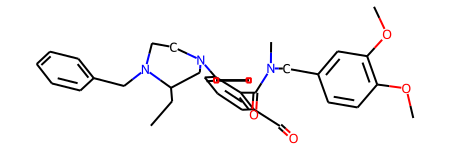

322.2480772733689

'CC.CC.CC.CCC1CN(c2cccc(C=O)c2C(=O)N(C)Cc2ccc(OC)c(OC)c2)CCN1Cc1ccccc1'

4

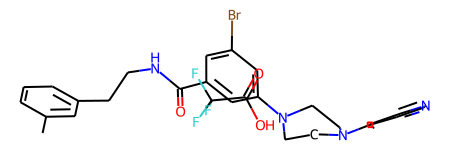

245.14030141830446

'Cc1cccc(CCNC(=O)c2cc(Br)cc(N3CCN(c4ccncc4)CC3)c2)c1.O=C(O)C(F)(F)F'

2

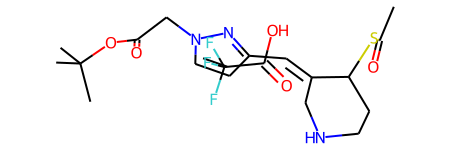

160.45271334648132

'CC(=O)SC1CCNC/C1=C\\c1ccn(CC(=O)OC(C)(C)C)n1.O=C(O)C(F)(F)F'

2

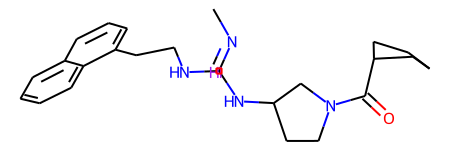

150.32658934593204

'CN=C(NCCc1cccc2ccccc12)NC1CCN(C(=O)C2CCCC2)C1.I'

2

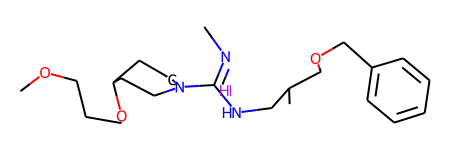

142.17174861431118

'CN=C(NCC(C)COCc1ccccc1)N1CCC(OCCCOC)CC1.I'

2

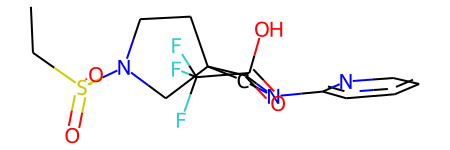

114.3691683292389

'CCS(=O)(=O)N1CCC2(CN(c3ccccn3)C2)C1.O=C(O)C(F)(F)F'

2

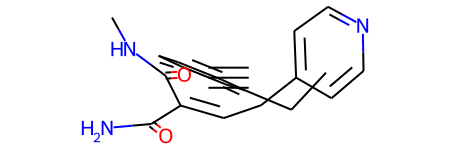

114.20517234802246

'C#C.CCc1ccccc1.CNC(=O)/C(=C\\Cc1ccncc1)C(N)=O'

3

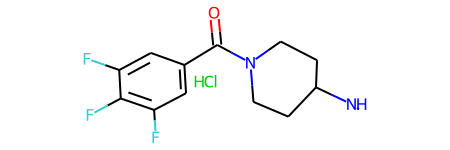

65.05394082069394

'CNC1CCN(C(=O)c2cc(F)c(F)c(F)c2)CC1.Cl'

2

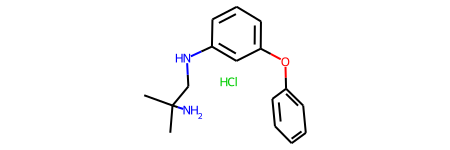

64.76949377059935

'CC(C)(N)CNc1cccc(Oc2ccccc2)c1.Cl'

2

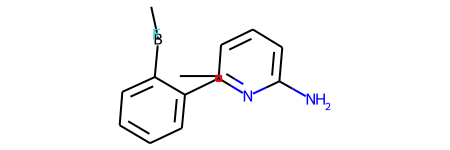

54.892967414855946

'CB(F)c1ccccc1-c1cccc(N)n1.CC'

2

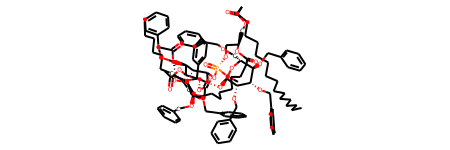

0.49467246532440184

'CCCCCCCCCCCCCCCCCC(=O)OC[C@H](CO[P@](=O)(OC)OC1[C@H](O[C@H]2O[C@H](COCc3ccccc3)[C@@H](OCc3ccccc3)[C@H](OCc3ccccc3)[C@@H]2OCc2ccccc2)[C@H](OC(C)=O)C(OC(C)=O)[C@H](OC(C)=O)[C@H]1O[C@H]1O[C@H](COCc2ccccc2)[C@@H](OCc2ccccc2)[C@H](OCc2ccccc2)[C@@H]1OCc1ccccc1)OC(=O)CCCCCCCCCCCCCCCCC'

1

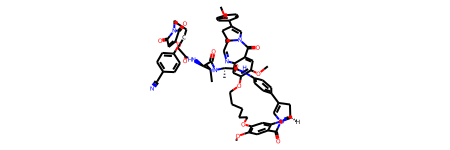

0.2126002073287964

'COc1ccc(C2=CN3C(=O)c4cc(OC)c(OCCCCCOc5cc6c(cc5OC)C(=O)N5C=C(c7ccc(NC(=O)[C@@H](C)NC(=O)[C@H](NC(=O)CCCCCN8C(=O)C=C(Oc9ccc(C#N)cc9)C8=O)C(C)C)cc7)C[C@H]5C=N6)cc4N=C[C@@H]3C2)cc1'

1

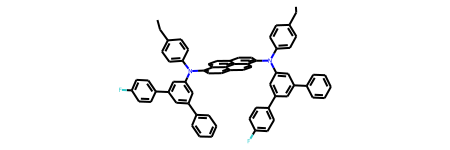

0.13072447776794432

'CCc1ccc(N(c2cc(-c3ccccc3)cc(-c3ccc(F)cc3)c2)c2ccc3ccc4c(N(c5ccc(CC)cc5)c5cc(-c6ccccc6)cc(-c6ccc(F)cc6)c5)ccc5ccc2c3c54)cc1'

1

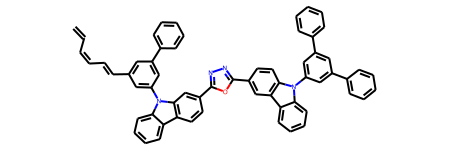

0.11600708961486815

'C=C/C=C\\C=C\\c1cc(-c2ccccc2)cc(-n2c3ccccc3c3ccc(-c4nnc(-c5ccc6c(c5)c5ccccc5n6-c5cc(-c6ccccc6)cc(-c6ccccc6)c5)o4)cc32)c1'

1

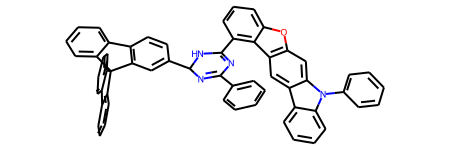

0.1151038408279419

'c1ccc(C2=NC(c3ccc4c(c3)C3(c5ccccc5-c5ccccc53)c3ccccc3-4)NC(c3cccc4oc5cc6c(cc5c34)c3ccccc3n6-c3ccccc3)=N2)cc1'

1

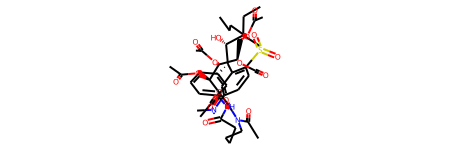

0.11417157649993898

'CCCC[C@@]1(CC)CS(=O)(=O)c2ccc(N(C)C)cc2[C@H](c2cccc(NC(=O)CCCCN(C(C)=O)C(=O)[C@H](OC(C)=O)[C@@H](OC(C)=O)[C@H](OC(C)=O)[C@@H](COC(C)=O)OC(C)=O)c2)[C@@H]1O'

1

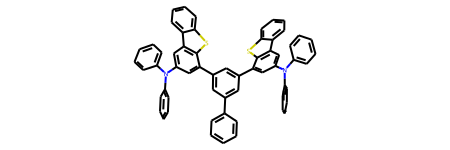

0.1074959993362427

'c1ccc(-c2cc(-c3cc(N(c4ccccc4)c4ccccc4)cc4c3sc3ccccc34)cc(-c3cc(N(c4ccccc4)c4ccccc4)cc4c3sc3ccccc34)c2)cc1'

1

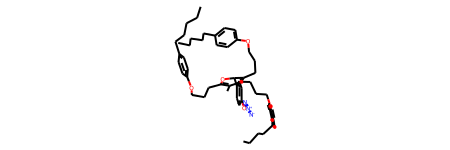

0.09422128200531005

'CCCCCc1ccc(OCCCC2=C(C)C(CCCOc3ccc(CCCCC)cc3)=C(CCCOc3ccc(CCCCC)cc3)C(c3ccc(ON=[N+]=[N-])cc3)O2)cc1'

1

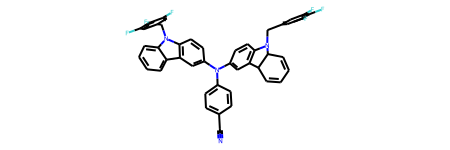

0.08590123653411866

'N#Cc1ccc(N(c2ccc3c(c2)C2C=CC=CC2N3Cc2cc(F)c(F)c(F)c2)c2ccc3c(c2)c2ccccc2n3Cc2cc(F)c(F)c(F)c2)cc1'

1

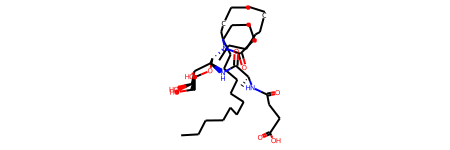

0.07826678752899169

'CCCCCCCCCCCCCCCCCC(=O)N(CCCCCCCCCCCC)[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1NC(=O)[C@H](C)NC(=O)CCC(=O)O'

1

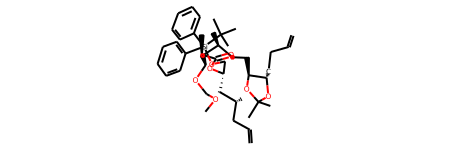

0.07806572914123536

'C=CCC[C@@H]1OC(C)(C)O[C@H]1CC[C@H](C)C[C@@H](OCOC)[C@@H](C)C(=O)O[C@H](CO[Si](c1ccccc1)(c1ccccc1)C(C)(C)C)C[C@H](C)CC=C'

1

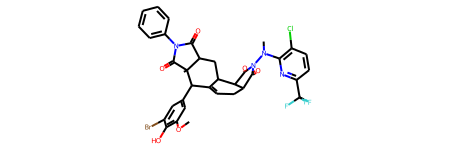

0.0759674310684204

'COc1cc(C2C3=CCC4C(=O)N(N(C)c5nc(C(F)(F)F)ccc5Cl)C(=O)C4C3CC3C(=O)N(c4ccccc4)C(=O)C32C)cc(Br)c1O'

1

In [101]:
times["sum"]=times[[n for red_name,n in ic.items()]].sum(1)
slow_ones=times[[n for red_name,n in ic.items()]].sum(0).sort_values(ascending=False).head(10).index
slow_idx=times[["sum"]+list(slow_ones)].sort_values("sum",ascending=False).head(22).index
for idx, m in zip(slow_idx,times.loc[slow_idx,"mol"]):
    display(m,times.loc[idx,"sum"],Chem.MolToSmiles(m),len(Chem.rdmolops.GetMolFrags(m)))

In [77]:
st = times["sum"].sort_values(ascending=False)
slow_ones = st[st>1].index
slow_ones = times.iloc[slow_ones]
slow_ones_sum=times.sum(0)
slow_ones_sum.sort_values(ascending=False)

sum                    1441.352964
CalcGETAWAY            1433.570438
LayeredFingerprint        0.238161
qed                       0.201148
EState_VSA6               0.167650
                          ...     
GetSSSR                   0.000064
RingCount                 0.000062
CalcNumHeterocycles       0.000060
CalcLabuteASA             0.000058
CalcNumRings              0.000043
Length: 249, dtype: float64

In [133]:
for red_name,n in ic.items():
    f,mod_name=succs[n]
    f_name="{}Featurizer".format(red_name)
    #m=bc
    print(n)
    mols=[Chem.Mol(m) for m in testmols]
    t0=time.time()
    for m in mols:
        r=f(m)
    tr=(time.time()-t0)
    time_factors[f_name]=tr
    break

tmw=time_factors["MolWtFeaturizer"]
minf=[None,10*10]
maxf=[None,0]
for k in time_factors:
    #time_factors[k]=time_factors[k]/tmw
    if time_factors[k]>maxf[1]:
        maxf=[k,time_factors[k]]
    if time_factors[k]<minf[1]:
        minf=[k,time_factors[k]]

minf,maxf,time_factors

MolWt
fr_sulfone
fr_Ar_N
fr_ester
VSA_EState7
fr_lactam
fr_aniline
CalcRadiusOfGyration
HallKierAlpha
fr_nitro_arom_nonortho
fr_Ndealkylation1
EState_VSA9
SlogP_VSA10
HeavyAtomMolWt
CalcPMI2
CalcChi2v
fr_NH2
CalcChi4n
Chi3n
Chi4v
CalcNumBridgeheadAtoms
SMR_VSA8
PMI3
NumRadicalElectrons
Chi1n
Chi0
PEOE_VSA2
fr_Ndealkylation2
fr_oxazole
BalabanJ
CalcNumAliphaticCarbocycles
SlogP_VSA2
EState_VSA1
Kappa3
MolLogP
fr_C_S
SlogP_VSA9
BCUT2D_MWHI
VSA_EState1
CalcPMI1
SMR_VSA1
CalcNumSaturatedRings
Kappa1
BCUT2D_MRHI
SMR_VSA3
EState_VSA8
fr_thiophene
fr_para_hydroxylation
VSA_EState8
GetFormalCharge
FpDensityMorgan2
MinPartialCharge
fr_morpholine
PEOE_VSA13
EState_VSA5
CalcNumHBA
CalcNumSaturatedCarbocycles
fr_lactone
PEOE_VSA5
MaxEStateIndex
fr_bicyclic
NumAromaticCarbocycles
HeavyAtomCount
fr_Ar_COO
PEOE_VSA6
CalcNumRotatableBonds
CalcNumAromaticRings
BertzCT
EState_VSA10
PEOE_VSA9
SlogP_VSA12
CalcNumLipinskiHBD
CalcChi0n
fr_C_O_noCOO
Eccentricity
CalcNumUnspecifiedAtomStereoCenters
fr_quatN
f

KeyboardInterrupt: 

In [134]:
import re
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()
    name=name.replace("__","_")
    name=name.replace("3_d","3d")
    name=name.replace("2_d","2d")
    return name


full_code="from ._molecule_featurizer import MoleculeFeaturizer,SingleValueMoleculeFeaturizer\n"
full_code+="import numpy as np\n"
full_code+="from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray\n"

for k,v in imports.items():
    full_code+="from {} import ({},)\n".format(k,",".join(v))
    
full_code+="\n"*2

for c in codes:
    full_code+=c+"\n\n"

available_featurizer=[]
for red_name in ic.keys():
    red_name=red_name
    sn="molecule_"+camel_to_snake(red_name)
    available_featurizer.append(sn)
    full_code+="{}={}()\n".format(sn,red_name+"Featurizer")

full_code+="\n"
full_code+="_available_featurizer={{\n{}\n}}\n".format(",\n".join(["'{}':{}".format(af,af) for af in available_featurizer]))

full_code+="""\n\n\n
def main():
    from rdkit import Chem
    testmol=Chem.MolFromSmiles("c1ccccc1")
    return list(zip(_available_featurizer,[f(testmol) for f in _available_featurizer]))
    
if __name__=='__main__':
    main()
"""

In [135]:
from molNet.featurizer import molecule_featurizer 
molecule_featurizer_dir = os.path.dirname(molecule_featurizer.__file__)
autogen_file=os.path.join(molecule_featurizer_dir,"_autogen_molecule_featurizer.py")
with open(autogen_file,"w+") as f:
    f.write(full_code)

In [136]:
from molNet.featurizer import _autogen_molecule_featurizer

In [137]:
molecule_featurizer.default_molecule_featurizer

default_molecule_featurizer(HeavyAtomCountFeaturizer,CrippenDescriptorsFeaturizer,NumAtomsFeaturizer,NumBondsFeaturizer,NumAliphaticCarbocyclesFeaturizer,NumAliphaticHeterocyclesFeaturizer,NumAliphaticRingsFeaturizer,NumAromaticCarbocyclesFeaturizer,NumAromaticHeterocyclesFeaturizer,NumAromaticRingsFeaturizer,NumBridgeheadAtomsFeaturizer,NumHBAFeaturizer,NumHBDFeaturizer,NumHeteroatomsFeaturizer,NumRingsFeaturizer,NumRotatableBondsFeaturizer,NumSaturatedRingsFeaturizer,NumSpiroAtomsFeaturizer)

In [138]:
_autogen_molecule_featurizer._available_featurizer

{'molecule_mol_wt': MolWtFeaturizer,
 'molecule_fr_sulfone': fr_sulfoneFeaturizer,
 'molecule_fr_ar_n': fr_ArNFeaturizer,
 'molecule_fr_ester': fr_esterFeaturizer,
 'molecule_vsa_e_state7': VSA_EState7Featurizer,
 'molecule_fr_lactam': fr_lactamFeaturizer,
 'molecule_fr_aniline': fr_anilineFeaturizer,
 'molecule_radius_of_gyration': RadiusOfGyrationFeaturizer,
 'molecule_hall_kier_alpha': HallKierAlphaFeaturizer,
 'molecule_fr_nitro_arom_nonortho': fr_nitro_arom_nonorthoFeaturizer,
 'molecule_fr_ndealkylation1': fr_Ndealkylation1Featurizer,
 'molecule_e_state_vsa9': EState_VSA9Featurizer,
 'molecule_slog_p_vsa10': SlogP_VSA10Featurizer,
 'molecule_heavy_atom_mol_wt': HeavyAtomMolWtFeaturizer,
 'molecule_pmi2': PMI2Featurizer,
 'molecule_chi2v': Chi2vFeaturizer,
 'molecule_fr_nh2': fr_NH2Featurizer,
 'molecule_chi4n': Chi4nFeaturizer,
 'molecule_chi3n': Chi3nFeaturizer,
 'molecule_chi4v': Chi4vFeaturizer,
 'molecule_num_bridgehead_atoms': NumBridgeheadAtomsFeaturizer,
 'molecule_smr_vsa

In [139]:
from importlib import reload  
from molNet.featurizer import _molecule_featurizer
reload(_molecule_featurizer)
reload(molecule_featurizer)
reload(_autogen_molecule_featurizer)
_autogen_molecule_featurizer.molecule_num_aromatic_rings.dtype

numpy.int32

In [140]:
_autogen_molecule_featurizer.molecule_num_aromatic_rings(testmols[1])

array([12], dtype=int32)